In [1]:
from copy import deepcopy
import cv2
import matplotlib
import numpy as np
import os  # ,fnmatch
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt


from brainbox.io.one import SessionLoader
# from ibldsp.smooth import smooth_interpolate_savgol  # Ines commented out; need to update iblenv to make this work
from one.api import ONE

In [3]:
one = ONE()

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


def load_pose(eid, cam, smoothed=False, manual=True, use_lp=True):

    '''
    cam in left, right, body 
    '''

    if manual:
        pth = one.eid2path(eid)
        if use_lp:
            d = pd.read_parquet(pth / 'alf' / f'_ibl_{cam}Camera.lightningPose.pqt')
        else:
            d = pd.read_parquet(pth / 'alf' / f'_ibl_{cam}Camera.dlc.pqt')
        d['times'] = np.load(one.eid2path(eid) / 'alf'
                    / f'_ibl_{cam}Camera.times.npy')
                    
        ls = [len(d[x]) for x in d]
        if not all(ls == np.mean(ls)):
            lsd = {x:len(d[x]) for x in d}
            print(f'length mismatch: {lsd}')
            print(eid, cam)
            print('cutting times')
            d['times'] = d['times'][:ls[0]]            

    else:
        # load DLC
        sess_loader = SessionLoader(one, eid)
        sess_loader.load_pose(views=[cam])
        d = sess_loader.pose[f'{cam}Camera']
    
    if smoothed:
        print('smoothing dlc traces')
        window = 13 if cam == 'right' else 7
        sers = [x for x in d.keys() if (x[-1] in ['x','y'])]# and 'paw' in x
        for ser in sers:
            d[ser] = smooth_interpolate_savgol(
                d[ser].to_numpy(),
                window=window,order=3, interp_kind='linear')   

    return d


def Viewer(eid, video_type, frame_start, frame_stop, save_video=True, 
           eye_zoom=False, lp=False, masked=True, paws_only=False,
           smooth_dlc = False
          ):
           
    '''
    eid: session id, e.g. '3663d82b-f197-4e8b-b299-7b803a155b84'
    video_type: one of 'left', 'right', 'body'
    save_video: video is saved this local folder

    Example usage to view and save labeled video with wheel angle:
    Viewer('3663d82b-f197-4e8b-b299-7b803a155b84', 'left', [5,7])

    '''

    save_vids_here = Path.home()/'Output LP'


    alf_path = one.eid2path(eid)

    # Download a single video
    video_path = (alf_path / 
        f'raw_video_data/_iblrig_{video_type}Camera.raw.mp4')
    
    if not os.path.isfile(video_path):
        print('mp4 not found locally, downloading it ...')
        video_path = one.load_dataset(eid,
            f'raw_video_data/_iblrig_{video_type}Camera.raw.mp4',
            download_only=True)


    # Download DLC traces and stamps
    Times = one.load_dataset(eid,f'alf/_ibl_{video_type}Camera.times.npy')

    print('loading pose')
    cam = load_pose(eid, video_type, smoothed=smooth_dlc, use_lp=lp)
                                                      
    # get video info
    cap = cv2.VideoCapture(video_path.as_uri())
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    size = (int(cap.get(3)), int(cap.get(4)))

    print(eid,
          ', ',
          video_type,
          ', fsp:',
          fps,
          ', #frames:',
          length,
          ', #stamps:',
          len(Times),
          ', #frames - #stamps = ',
          length - len(Times))

    # pick trial range for which to display stuff
    trials = one.load_object(eid, 'trials')

    print('frame start stop', frame_start, frame_stop)

    '''
    load wheel
    '''

    wheel = one.load_object(eid, 'wheel')
    import brainbox.behavior.wheel as wh
    try:
        pos, t = wh.interpolate_position(
            wheel['timestamps'], wheel['position'], freq=1000)
    except BaseException:
        pos, t = wh.interpolate_position(
            wheel['times'], wheel['position'], freq=1000)

    w_start = find_nearest(t, Times[frame_start])
    w_stop = find_nearest(t, Times[frame_stop])

    # confine to interval
    pos_int = pos[w_start:w_stop]
    t_int = t[w_start:w_stop]

    # alignment of cam stamps and interpolated wheel stamps
    wheel_pos = []
    kk = 0
    for wt in Times[frame_start:frame_stop]:
        wheel_pos.append(pos_int[find_nearest(t_int, wt)])
        kk += 1
        if kk % 3000 == 0:
            print('iteration', kk)

    '''
    DLC related stuff
    '''
    Times = Times[frame_start:frame_stop]
    Frames = np.arange(frame_start, frame_stop)
    
    
    # liklihood threshold
    l_thr = 0.9 if masked else -1

    points = [x[:-2] for x in cam.keys() if x[-1] == 'x']

    if video_type != 'body':
        try:
            d = list(points)
            d.remove('tube_top')
            d.remove('tube_bottom')
            points = d
        except:
            pass

    if paws_only:
        p2 = deepcopy(points)
        for point in p2:
            if not 'paw' in point:
                points.remove(point)            

    points = np.array(points)        
        
    # Set values to nan if likelyhood is too low # for pqt: .to_numpy()
    XYs = {}
    zscores = {}  # Ines added
    for point in points:
        x = np.ma.masked_where(
            cam[point + '_likelihood'] < l_thr, cam[point + '_x'])
        x = x.filled(np.nan)
        y = np.ma.masked_where(
            cam[point + '_likelihood'] < l_thr, cam[point + '_y'])
        y = y.filled(np.nan)
        XYs[point] = np.array(
            [x[frame_start:frame_stop], y[frame_start:frame_stop]])    
        if 'pupil' in point or 'paw' in point:    
            zsc = np.ma.masked_where(
                cam[point + '_likelihood'] < l_thr, cam[point + '_zscore'])
            zsc = zsc.filled(np.nan)
            zscores[point] = np.array(
                zsc[frame_start:frame_stop])
                   
        

    # Just for 3D testing
    # return XYs

    # Zoom at eye
    if eye_zoom:
        pivot = np.nanmean(XYs['pupil_top_r'], axis=1)
        x0 = int(pivot[0]) - 33
        x1 = int(pivot[0]) + 33
        y0 = int(pivot[1]) - 28
        y1 = int(pivot[1]) + 38
        size = (66, 66)
        dot_s = 1  # [px] for painting DLC dots

    else:
        x0 = 0
        x1 = size[0]
        y0 = 0
        y1 = size[1]
        if video_type == 'left':
            dot_s = 10  # [px] for painting DLC dots
        else:
            dot_s = 5

    if save_video:
    
        loc = (save_vids_here / 
        f'{eid}_{video_type}_frames_{frame_start}_{frame_stop}'
        f'_lp_{lp}.mp4')

        out = cv2.VideoWriter(str(loc),
                              cv2.VideoWriter_fourcc(*'mp4v'),
                              fps,
                              size)  # put , 0 if grey scale

    # writing stuff on frames
    font = cv2.FONT_HERSHEY_SIMPLEX

    if video_type == 'left':
        bottomLeftCornerOfText = (20, 1000)
        fontScale = 4
    else:
        bottomLeftCornerOfText = (10, 500)
        fontScale = 2

    lineType = 2

    # assign a color to each DLC point (now: all points red)
    cmap = matplotlib.cm.get_cmap('Set1')
    CR = np.arange(len(points)) / len(points)

    block = np.ones((2 * dot_s, 2 * dot_s, 3))

    # set start frame
    cap.set(1, frame_start)

    k = 0
    while(cap.isOpened()):
        ret, frame = cap.read()
        gray = frame

        # print wheel angle
        fontColor = (255, 255, 255)
        Angle = round(wheel_pos[k], 2)
        Time = round(Times[k], 3)
        cv2.putText(gray,
                    'Wheel angle: ' + str(Angle),
                    bottomLeftCornerOfText,
                    font,
                    fontScale / 2,
                    fontColor,
                    lineType)

        a, b = bottomLeftCornerOfText
        bottomLeftCornerOfText0 = (int(a * 10 + b / 2), b)
        cv2.putText(gray,
                    '  time: ' + str(Time),
                    bottomLeftCornerOfText0,
                    font,
                    fontScale / 2,
                    fontColor,
                    lineType)
                    
                    
        bottomLeftCornerOfText1 = (a, b - 3* a)
        cv2.putText(gray,
                    'Frame: ' + str(Frames[k]),
                    bottomLeftCornerOfText1,
                    font,
                    fontScale / 2,
                    fontColor,
                    lineType)                    
                    
                    

        # print DLC dots
        ll = 0
        for point in points:

            # Put point color legend
            fontColor = (np.array([cmap(CR[ll])]) * 255)[0][:3]
            a, b = bottomLeftCornerOfText
            if video_type == 'right':
                bottomLeftCornerOfText2 = (a, a * 2 * (1 + ll))
            else:
                bottomLeftCornerOfText2 = (b, a * 2 * (1 + ll))
            fontScale2 = fontScale / 4
            cv2.putText(gray, point,
                        bottomLeftCornerOfText2,
                        font,
                        fontScale2,
                        fontColor,
                        lineType)              

            X0 = XYs[point][0][k]
            Y0 = XYs[point][1][k]
            if 'pupil' in point or 'paw' in point:
                ZSCORE = zscores[point][k]  # Ines added
            # transform for opencv?
            X = Y0
            Y = X0

            if not np.isnan(X) and not np.isnan(Y):
                col = (np.array([cmap(CR[ll])]) * 255)[0][:3]
                # col = np.array([0, 0, 255]) # all points red
                if 'pupil' in point or 'paw' in point:
                    # Ines added
                    if ZSCORE > 1:
                        col = np.array([0, 0, 255]) # red
                    elif ZSCORE < .5:
                        col = np.array([0, 255, 0]) # green
                    elif .5 <= ZSCORE <= 1:
                        col = np.array([0, 255, 255]) # yellow
                X = X.astype(int)
                Y = Y.astype(int)
                gray[X - dot_s:X + dot_s, Y - 
                     dot_s:Y + dot_s] = block * col            

            ll += 1

        gray = gray[y0:y1, x0:x1]
        if save_video:
            out.write(gray)
        k += 1
        if k == (frame_stop - frame_start) - 1:
            break

    if save_video:
        out.release()
    cap.release()
    
    print(eid, video_type, frame_start, frame_stop)


/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/one/api.py:1465: UserWarning: Newer cache tables require ONE version 2.7 or greater
  warnings.warn(f'Newer cache tables require ONE version {min_version} or greater')


In [50]:
# eids of interest
eid = "7330f879-8dfc-4344-af84-cd422199bddc"  # KS014 21/08/2019
# eid = "c4a4d9d8-a5f6-48b6-b4b6-a23f3f76e9ee"  # KS014 20/08/2019
# eid = "616e7cfa-ba4d-4fbf-9400-dc0640f8238f"  # KS014 19/08/2019

video_type = 'left'
smooth_dlc = False
lp = True
masked = True
paws_only = False
frame_start = 1
frame_stop = 1000

In [51]:

'''
eid: session id, e.g. '3663d82b-f197-4e8b-b299-7b803a155b84'
video_type: one of 'left', 'right', 'body'
save_video: video is saved this local folder

Example usage to view and save labeled video with wheel angle:
Viewer('3663d82b-f197-4e8b-b299-7b803a155b84', 'left', [5,7])

'''

save_vids_here = Path.home()/'Output LP'


alf_path = one.eid2path(eid)

# Download a single video
video_path = (alf_path / 
    f'raw_video_data/_iblrig_{video_type}Camera.raw.mp4')

if not os.path.isfile(video_path):
    print('mp4 not found locally, downloading it ...')
    video_path = one.load_dataset(eid,
        f'raw_video_data/_iblrig_{video_type}Camera.raw.mp4',
        download_only=True)


# Download DLC traces and stamps
Times = one.load_dataset(eid,f'alf/_ibl_{video_type}Camera.times.npy')

print('loading pose')
cam = load_pose(eid, video_type, smoothed=smooth_dlc, use_lp=lp)
                                                    
# get video info
cap = cv2.VideoCapture(video_path.as_uri())
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(3)), int(cap.get(4)))

print(eid,
        ', ',
        video_type,
        ', fsp:',
        fps,
        ', #frames:',
        length,
        ', #stamps:',
        len(Times),
        ', #frames - #stamps = ',
        length - len(Times))

# pick trial range for which to display stuff
trials = one.load_object(eid, 'trials')


'''
DLC related stuff
'''
Times = Times[frame_start:frame_stop]
Frames = np.arange(frame_start, frame_stop)


# liklihood threshold
l_thr = 0.9 if masked else -1

points = [x[:-2] for x in cam.keys() if x[-1] == 'x']

if video_type != 'body':
    try:
        d = list(points)
        d.remove('tube_top')
        d.remove('tube_bottom')
        points = d
    except:
        pass

if paws_only:
    p2 = deepcopy(points)
    for point in p2:
        if not 'paw' in point:
            points.remove(point)            

points = np.array(points)        
    
# Set values to napaws_onlyn if likelyhood is too low # for pqt: .to_numpy()
XYs = {}
zscores = {}  # Ines added
for point in points:
    x = np.ma.masked_where(
        cam[point + '_likelihood'] < l_thr, cam[point + '_x'])
    x = x.filled(np.nan)
    y = np.ma.masked_where(
        cam[point + '_likelihood'] < l_thr, cam[point + '_y'])
    y = y.filled(np.nan)
    XYs[point] = np.array(
        [x[frame_start:frame_stop], y[frame_start:frame_stop]])    
    if 'pupil' in point or 'paw' in point:    
        zsc = np.ma.masked_where(
            cam[point + '_likelihood'] < l_thr, cam[point + '_zscore'])
        zsc = zsc.filled(np.nan)
        zscores[point] = np.array(
            zsc[frame_start:frame_stop])
                   


loading pose
7330f879-8dfc-4344-af84-cd422199bddc ,  left , fsp: 30.0 , #frames: 335660 , #stamps: 335660 , #frames - #stamps =  0


(0.0, 1000.0)

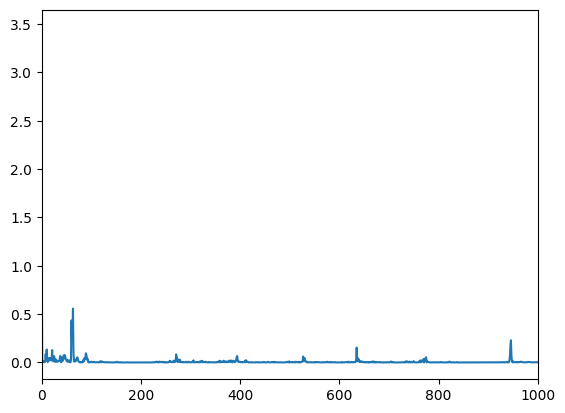

In [54]:
plt.plot(cam['paw_l_zscore'])
plt.xlim([0, 1000])

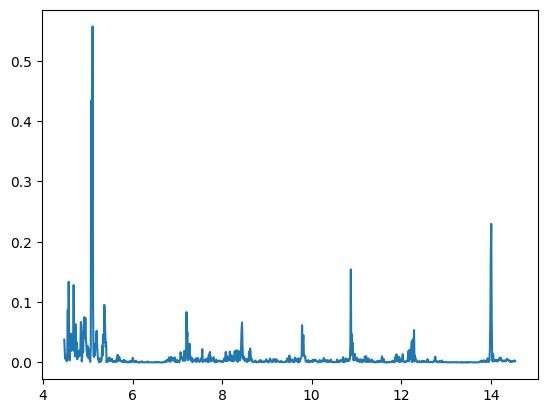

(array([3.11479e+05, 1.04080e+04, 4.47900e+03, 2.44400e+03, 1.56700e+03,
        1.06500e+03, 8.17000e+02, 6.06000e+02, 4.57000e+02, 4.09000e+02,
        2.62000e+02, 2.42000e+02, 2.22000e+02, 1.78000e+02, 1.17000e+02,
        1.09000e+02, 1.02000e+02, 8.10000e+01, 7.30000e+01, 4.50000e+01,
        5.20000e+01, 4.20000e+01, 3.80000e+01, 4.70000e+01, 3.80000e+01,
        2.00000e+01, 2.00000e+01, 1.80000e+01, 1.30000e+01, 1.50000e+01,
        1.70000e+01, 1.10000e+01, 1.60000e+01, 1.20000e+01, 8.00000e+00,
        1.00000e+01, 8.00000e+00, 8.00000e+00, 3.00000e+00, 3.00000e+00,
        9.00000e+00, 1.30000e+01, 5.00000e+00, 3.00000e+00, 7.00000e+00,
        2.00000e+00, 8.00000e+00, 3.00000e+00, 6.00000e+00, 3.00000e+00,
        4.00000e+00, 4.00000e+00, 2.00000e+00, 6.00000e+00, 4.00000e+00,
        1.00000e+00, 2.00000e+00, 1.00000e+00, 4.00000e+00, 2.00000e+00,
        0.00000e+00, 2.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00,
        1.00000e+00, 0.00000e+00, 0.00000e+00, 0.00

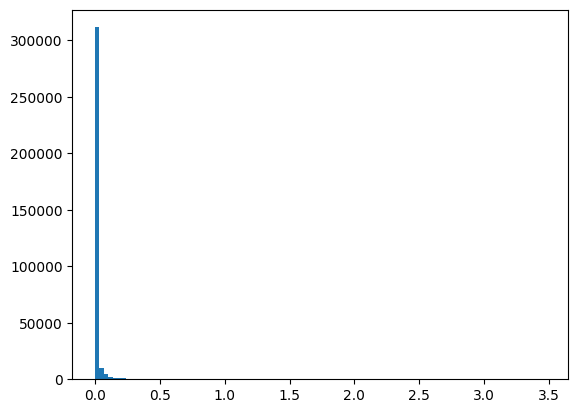

In [53]:
import matplotlib.pyplot as plt
plt.plot(Times, cam['paw_l_zscore'][frame_start:frame_stop])
plt.show()
plt.hist(cam['paw_l_zscore'], bins=100)


In [ ]:

'''
eid: session id, e.g. '3663d82b-f197-4e8b-b299-7b803a155b84'
video_type: one of 'left', 'right', 'body'
save_video: video is saved this local folder

Example usage to view and save labeled video with wheel angle:
Viewer('3663d82b-f197-4e8b-b299-7b803a155b84', 'left', [5,7])

'''

save_vids_here = Path.home()/'Output LP'


alf_path = one.eid2path(eid)

# Download a single video
video_path = (alf_path / 
    f'raw_video_data/_iblrig_{video_type}Camera.raw.mp4')

if not os.path.isfile(video_path):
    print('mp4 not found locally, downloading it ...')
    video_path = one.load_dataset(eid,
        f'raw_video_data/_iblrig_{video_type}Camera.raw.mp4',
        download_only=True)


# Download DLC traces and stamps
Times = one.load_dataset(eid,f'alf/_ibl_{video_type}Camera.times.npy')

print('loading pose')
cam = load_pose(eid, video_type, smoothed=smooth_dlc, use_lp=lp)
                                                    
# get video info
cap = cv2.VideoCapture(video_path.as_uri())
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = cap.get(cv2.CAP_PROP_FPS)
size = (int(cap.get(3)), int(cap.get(4)))

print(eid,
        ', ',
        video_type,
        ', fsp:',
        fps,
        ', #frames:',
        length,
        ', #stamps:',
        len(Times),
        ', #frames - #stamps = ',
        length - len(Times))

# pick trial range for which to display stuff
trials = one.load_object(eid, 'trials')


'''
load wheel
'''

wheel = one.load_object(eid, 'wheel')
import brainbox.behavior.wheel as wh
try:
    pos, t = wh.interpolate_position(
        wheel['timestamps'], wheel['position'], freq=1000)
except BaseException:
    pos, t = wh.interpolate_position(
        wheel['times'], wheel['position'], freq=1000)

w_start = find_nearest(t, Times[frame_start])
w_stop = find_nearest(t, Times[frame_stop])

# confine to interval
pos_int = pos[w_start:w_stop]
t_int = t[w_start:w_stop]

# alignment of cam stamps and interpolated wheel stamps
wheel_pos = []
kk = 0
for wt in Times[frame_start:frame_stop]:
    wheel_pos.append(pos_int[find_nearest(t_int, wt)])
    kk += 1
    if kk % 3000 == 0:
        print('iteration', kk)

'''
DLC related stuff
'''
Times = Times[frame_start:frame_stop]
Frames = np.arange(frame_start, frame_stop)


# liklihood thresholdpaws_only
l_thr = 0.9 if masked else -1

points = [x[:-2] for x in cam.keys() if x[-1] == 'x']

if video_type != 'body':
    try:
        d = list(points)
        d.remove('tube_top')
        d.remove('tube_bottom')
        points = d
    except:
        pass

if paws_only:
    p2 = deepcopy(points)
    for point in p2:
        if not 'paw' in point:
            points.remove(point)            

points = np.array(points)        
    
# Set values to nan if likelyhood is too low # for pqt: .to_numpy()
XYs = {}
zscores = {}  # Ines added
for point in points:
    x = np.ma.masked_where(
        cam[point + '_likelihood'] < l_thr, cam[point + '_x'])
    x = x.filled(np.nan)
    y = np.ma.masked_where(
        cam[point + '_likelihood'] < l_thr, cam[point + '_y'])
    y = y.filled(np.nan)
    XYs[point] = np.array(
        [x[frame_start:frame_stop], y[frame_start:frame_stop]])    
    if 'pupil' in point or 'paw' in point:    
        zsc = np.ma.masked_where(
            cam[point + '_likelihood'] < l_thr, cam[point + '_zscore'])
        zsc = zsc.filled(np.nan)
        zscores[point] = np.array(
            zsc[frame_start:frame_stop])
                   